- Aim of this notebook
    - Train a function that can convert graph into graph embeddings
    - Given a graph, learn embeddings of the nodes using only the graph structure and the node features, without using any known node class labels
    - How this graph embeddings can be used for recommendation?
        - Use cosine similarity between user node and the listing node as a feature to predict the rating the user will put on all the listings, then rank by rating accordingly
        - Use K nearest neighbors (Research pinsage)
        - approximate nearest neighbor search
            - [FAISS](https://github.com/facebookresearch/faiss/wiki) from Facebook
            - [Annoy](https://github.com/spotify/annoy) from Spotify
            - [Scann](https://github.com/google-research/google-research/tree/master/scann?source=techstories.org) from Google (which is to date the fastest implementation to date)
    - Need to have a baseline model like matrix factorization model/ random generated list
- Possible improvements
    - user embeddings could be the embeddings of their own profile picture
    - PinnerSage
    - Use Uber hingeloss
    - Use rating difference as loss
    - built a listing-to-listing graph, connecting listings if the same user reviews on both
    
- Need to consider that numbers in some columns will grow over times
- This is where CT may come in by considering the host_joined_date
    - Assume all the listings owned by host are published since host_joined_date

In [1]:
import pandas as pd
import json
import numpy as np

In [2]:
directory = "../../data/processed"

reviews = pd.read_parquet(f'{directory}/reviews_with_interactions.parquet')
listings = pd.read_parquet(f'{directory}/listings_with_interactions.parquet')
reviewers = pd.read_parquet(f'{directory}/reviewers_with_interactions.parquet')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442687 entries, 0 to 1459535
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   listing_id             1442687 non-null  object             
 1   id                     1442687 non-null  object             
 2   rating                 1442687 non-null  int64              
 3   comments               1442687 non-null  object             
 4   localized_comments     440951 non-null   object             
 5   response               165434 non-null   object             
 6   localized_response     40491 non-null    object             
 7   language               1442627 non-null  object             
 8   created_at             1442687 non-null  datetime64[ns, UTC]
 9   localized_date         1442687 non-null  object             
 10  reviewee_id            1442687 non-null  object             
 11  reviewee_first_name    1

In [3]:
features_col_dict_f = open("./features_col_dict.json")
features_col_dict_dict = json.load(features_col_dict_f)
features_cols = features_col_dict_dict['features_cols']
print(f"Num of Listing Features: {(len(features_cols))}\n")
listings.info()

Num of Listing Features: 159

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20799 entries, 0 to 24286
Columns: 162 entries, num_of_guest_capacity to listing_id
dtypes: bool(124), category(8), datetime64[ns](1), float64(27), object(2)
memory usage: 7.6+ MB


In [4]:
# Convert data type
for col in listings.select_dtypes(include=["bool", "float"]):
    listings[col] = listings[col].astype("category")

In [5]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24287 entries, 0 to 24286
Columns: 162 entries, num_of_guest_capacity to listing_id
dtypes: category(159), datetime64[ns](1), object(2)
memory usage: 5.8+ MB


In [15]:
listings.select_dtypes(include=["category", "float"])
# listings['house_rule_is_self_checkIn'].values

,num_of_guest_capacity,num_of_bedroom,num_of_private_bedroom,num_of_bed,num_of_room,num_of_private_bath,num_of_shared_bath,num_of_studio,num_of_bath,house_rule_is_smoking_allowed,...,sleeping_arrangement_num_of_day_bed,sleeping_arrangement_num_of_futon_bed,sleeping_arrangement_num_of_murphy_bed,sleeping_arrangement_num_of_water_bed,price_per_night,country,listing_type,lat,lng,listing_detail_type
0,6.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,NO,...,0.0,0.0,0.0,0.0,179.0,Malaysia,Entire villa,2.42838,103.98195,NORMAL
1,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.5,UNKNOWN,...,0.0,0.0,0.0,0.0,69.0,Turkey,Entire villa,36.52348,29.44096,NORMAL
2,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,YES,...,0.0,0.0,0.0,0.0,83.0,Australia,Camper/RV,-28.29705,153.52477,NORMAL
3,6.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,UNKNOWN,...,0.0,0.0,0.0,0.0,227.0,France,Treehouse,48.28018,6.91658,NORMAL
4,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NO,...,0.0,0.0,0.0,0.0,58.0,South Korea,Private room in cottage,33.24142,126.36848,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24282,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,UNKNOWN,...,0.0,0.0,0.0,0.0,14.0,Colombia,Private room in home,10.41890,-75.54650,NORMAL
24283,4.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,NO,...,0.0,0.0,0.0,0.0,102.0,United Kingdom,Entire home,51.29560,-0.43770,NORMAL
24284,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NO,...,0.0,0.0,0.0,0.0,66.0,Taiwan,Private room in home,24.32693,120.92114,NORMAL
24285,14.0,4.0,0.0,9.0,0.0,0.0,0.0,0.0,3.0,NO,...,0.0,0.0,0.0,0.0,111.0,Malaysia,Entire home,4.48898,101.37294,NORMAL


In [18]:
#no of unique reviewee / people who host
print(reviews['reviewee_id'].nunique())
#no of unique reviewer / people who rent
print(reviews['reviewer_id'].nunique())
#no of unique listing from reviews dataset
print(reviews['listing_id'].nunique())


17249
1378157
21265


In [20]:
common_list = set(list(reviews['listing_id'].unique())).intersection(list(listings['listing_id'].unique()))
len(common_list)

20843

In [24]:
listings['num_of_guest_capacity'].values

array([ 6.,  4.,  2., ...,  2., 14.,  4.])

In [5]:
# Is it possible that the host might be also the customer
common_list = set(list(reviews['reviewee_id'].unique())).intersection(list(reviews['reviewer_id'].unique()))
print(len(common_list))

705


In [31]:
reviews['reviewee_is_superhost'].value_counts()

False    1463514
Name: reviewee_is_superhost, dtype: int64

In [7]:
listings[listings['listing_id'].isin(reviews['listing_id'].unique())]

,num_of_guest_capacity,num_of_bedroom,num_of_private_bedroom,num_of_bed,num_of_room,num_of_private_bath,num_of_shared_bath,num_of_studio,num_of_bath,house_rule_is_self_checkIn,...,amenity_has_PING_PONG,amenity_has_VIEW_CITY,amenity_has_FIREPLACE_GUARD,amenity_has_CHANGING_DIAPER_TABLE,amenity_has_PORTABLE_WI_FI,amenity_has_BABY_MONITOR,amenity_has_OUTLET_COVER,amenity_has_TRASH_COMPACTOR,amenity_has_PIANO,amenity_has_VIDEO_GAME
0,6.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,True,...,False,False,False,False,False,False,False,False,False,False
1,4.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.5,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,...,False,False,False,False,False,False,False,False,False,False
3,6.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,False,...,False,False,False,False,False,False,False,False,False,False
4,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24282,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,False,...,False,False,False,False,False,False,False,False,False,False
24283,4.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,True,...,False,False,False,False,False,False,False,False,False,False
24284,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,...,False,False,False,False,False,False,False,False,False,False
24285,14.0,4.0,0.0,9.0,0.0,0.0,0.0,0.0,3.0,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
filtered = reviews[reviews['listing_id'].isin(listings['listing_id'].unique())]
((len(reviews) - len(filtered)) / len(reviews)) * 100

1.155574869799674

In [24]:
# Check whether there is a user who rent listing more than once
# filtered.groupby('reviewer_id')['listing_id'].value_counts().unique()

array([ 1,  2,  3,  4,  5, 10,  8,  7,  6, 20,  9, 18, 15, 11, 12, 14, 13,
       26, 23, 16, 19, 31])

In [262]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442687 entries, 0 to 1459535
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   listing_id             1442687 non-null  object             
 1   id                     1442687 non-null  object             
 2   rating                 1442687 non-null  int64              
 3   comments               1442687 non-null  object             
 4   localized_comments     440951 non-null   object             
 5   response               165434 non-null   object             
 6   localized_response     40491 non-null    object             
 7   language               1442627 non-null  object             
 8   created_at             1442687 non-null  datetime64[ns, UTC]
 9   localized_date         1442687 non-null  object             
 10  reviewee_id            1442687 non-null  object             
 11  reviewee_first_name    1

In [263]:
reviews['month_by_year'] = reviews['created_at'].dt.to_period('M')


/var/folders/mr/dg98_zmd5d90zd_4275kp9r00000gn/T/ipykernel_10280/3081546601.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  reviews['month_by_year'] = reviews['created_at'].dt.to_period('M')


In [264]:
a = reviews.groupby('month_by_year')['id'].count()

<AxesSubplot: xlabel='month_by_year'>

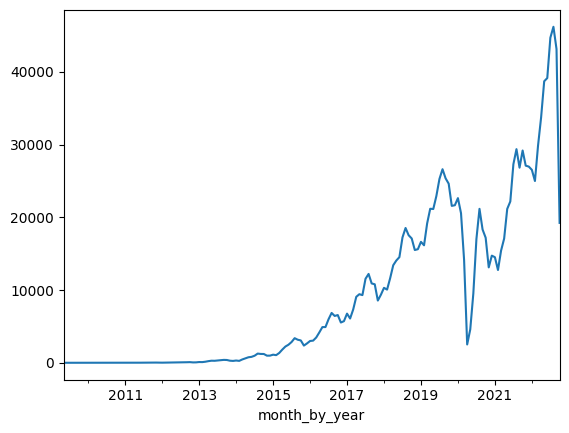

In [265]:
a.plot()

In [266]:
reviews['created_at'].min()

Timestamp('2009-05-23 16:27:17+0000', tz='UTC')

In [267]:
len(reviews) * 0.7

1009880.8999999999

In [276]:
# cos = cosine_similarity(user_embeddings[0].detach().numpy().reshape(1, -1), listing_embeddings.detach().numpy())
# top_ids = np.argsort(-cos)[0] 
# [test_listings.iloc[index]['listing_id'] for index in top_ids[:10]]

In [277]:
v = test_reviews['reviewer_id'].value_counts()
reviews_that_user_interaction_more_than_once = test_reviews[test_reviews['reviewer_id'].isin(v.index[v.gt(1)])]
reviews_that_user_interaction_more_than_once

,listing_id,id,rating,comments,localized_comments,response,localized_response,language,created_at,localized_date,...,reviewee_host_name,reviewee_is_superhost,reviewee_picture_url,reviewer_id,reviewer_first_name,reviewer_host_name,reviewer_is_superhost,reviewer_picture_url,timestamp,month_by_year
108,42505776,725152104959109156,5,Een prachtige locatie om echt de beleving mee ...,A beautiful location to really get the experie...,None,None,nl,2022-09-27 12:27:47+00:00,September 2022,...,Vincenzo,False,https://a0.muscache.com/im/pictures/user/a6500...,44001939,Roxanne,Roxanne,False,https://a0.muscache.com/im/pictures/user/bda82...,1664281667,2022-09
247,39402505,706195264734124567,5,host friendly. easy to check in and check out....,None,None,None,en,2022-09-01 08:43:55+00:00,September 2022,...,Benedict,False,https://a0.muscache.com/im/pictures/user/4032e...,370576071,A,A,False,https://a0.muscache.com/im/pictures/user/eb4d8...,1662021835,2022-09
337,52980369,694466583933108924,5,"Great host, communication, location, such a co...",None,"Hi Bo,\r<br/>We really enjoy hearing from gues...",None,en,2022-08-16 04:21:08+00:00,August 2022,...,Verina,False,https://a0.muscache.com/im/pictures/user/bcb9f...,15596588,Bo,Bo,False,https://a0.muscache.com/im/pictures/user/6a3ee...,1660623668,2022-08
340,52980369,679266712086147756,5,"Great for a family holiday, lots of character ...",None,"Hi Mikaela,\r<br/>We're so pleased to hear you...",None,en,2022-07-26 05:01:42+00:00,July 2022,...,Verina,False,https://a0.muscache.com/im/pictures/user/bcb9f...,267556130,Mikaela,Mikaela,False,https://a0.muscache.com/im/pictures/user/43fc7...,1658811702,2022-07
345,52980369,664828663113242306,5,Unique house in a nice location. It has lots o...,None,"Hi Cat,\r<br/>We're so pleased to hear you had...",None,en,2022-07-06 06:55:52+00:00,July 2022,...,Verina,False,https://a0.muscache.com/im/pictures/user/bcb9f...,389038492,Cat,Cat,False,https://a0.muscache.com/im/pictures/user/ef5f6...,1657090552,2022-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459271,46798735,593081195201924715,4,Stayed here for 4 nights total. Everywhere you...,None,None,None,en,2022-03-29 07:06:27+00:00,March 2022,...,Villa V Uluwatu,False,https://a0.muscache.com/im/pictures/user/305ad...,364794803,Tuva,Tuva,False,https://a0.muscache.com/im/pictures/user/d8823...,1648537587,2022-03
1459299,46798735,554722751593217540,5,"Die Unterkunft ist ein wahrgewordener Traum, s...","The accommodation is a dream come true, very m...",None,None,de,2022-02-04 08:55:05+00:00,February 2022,...,Villa V Uluwatu,False,https://a0.muscache.com/im/pictures/user/305ad...,44418675,Florian,Florian,False,https://a0.muscache.com/im/pictures/user/84034...,1643964905,2022-02
1459318,13670321,726657885124962111,5,"This was a phenomenal location, better than I ...",None,None,None,en,2022-09-29 14:19:30+00:00,September 2022,...,Andrea,False,https://a0.muscache.com/im/pictures/user/33352...,8184382,Jen,Jen,False,https://a0.muscache.com/im/pictures/user/51d34...,1664461170,2022-09
1459353,30152132,610461462579709831,5,My husband and I stayed here for a few nights ...,None,None,None,en,2022-04-22 06:37:57+00:00,April 2022,...,André,False,https://a0.muscache.com/im/pictures/user/afb4f...,121598206,Kesley,Kesley,False,https://a0.muscache.com/im/pictures/user/fecdc...,1650609477,2022-04


In [279]:
reviews_that_user_interaction_more_than_once['reviewer_id'].value_counts()

436290388    16
254229827    12
276816016    10
4535454      10
69165810      9
             ..
434519526     2
305673357     2
367477590     2
31020091      2
136166923     2
Name: reviewer_id, Length: 9644, dtype: int64

In [188]:
user_interactions = reviews_that_user_interaction_more_than_once[reviews_that_user_interaction_more_than_once['reviewer_id'] == '21000874']
display(user_interactions.sort_values(by='created_at')[['listing_id','created_at']])
query_listing_id = user_interactions.sort_values(by='created_at').iloc[0]['listing_id']
ground_truth_list = user_interactions[~user_interactions['listing_id'].isin([query_listing_id])]['listing_id'].values
print(query_listing_id)
print(ground_truth_list)

,listing_id,created_at
563513,24043648,2022-05-08 07:17:49+00:00
96758,25718297,2022-05-09 06:40:01+00:00
1157389,29570787,2022-05-14 05:02:22+00:00
46899,47413555,2022-05-17 06:05:56+00:00
1187883,1016153,2022-05-19 07:01:24+00:00
517765,49371320,2022-05-22 07:17:01+00:00
963048,24162736,2022-05-24 06:01:09+00:00
1104912,47017064,2022-05-26 07:08:11+00:00


24043648
['47413555' '25718297' '49371320' '24162736' '47017064' '29570787'
 '1016153']


In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GraphSAGE

dataset = 'Cora'
path = osp.join('..', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

train_loader = LinkNeighborLoader(
    data,
    batch_size=256,
    shuffle=True,
    neg_sampling_ratio=1.0,
    num_neighbors=[10, 10],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(data.num_node_features, hidden_channels=64,
                  num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x.to(device), data.edge_index.to(device)

print("data", data)

def train():
    model.train()

    total_loss = 0
    for batch in train_loader:
        print("batch", batch)
        batch = batch.to(device)
        optimizer.zero_grad()
        h = model(batch.x, batch.edge_index)
        h_src = h[batch.edge_label_index[0]]
        h_dst = h[batch.edge_label_index[1]]
        pred = (h_src * h_dst).sum(dim=-1)
        print(pred.shape)
        print(batch.edge_label.shape)
        loss = F.binary_cross_entropy_with_logits(pred, batch.edge_label)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.size(0)
    return total_loss / data.num_nodes


@torch.no_grad()
def test():
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device)).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc


for epoch in range(1, 2):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

OSError: dlopen(/Users/yhchan/opt/anaconda3/envs/ty/lib/python3.10/site-packages/libpyg.so, 0x0006): Library not loaded: '/Users/runner/hostedtoolcache/Python/3.10.8/x64/lib/libpython3.10.dylib'
  Referenced from: '/Users/yhchan/opt/anaconda3/envs/ty/lib/python3.10/site-packages/libpyg.so'
  Reason: tried: '/Users/runner/hostedtoolcache/Python/3.10.8/x64/lib/libpython3.10.dylib' (no such file), '/usr/local/lib/libpython3.10.dylib' (no such file), '/usr/lib/libpython3.10.dylib' (no such file)

In [20]:
batch = next(iter(train_loader))

data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [22]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [21]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [28]:
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import LinkNeighborLoader

data = Planetoid(path, name='Cora')[0]

loader = LinkNeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30] * 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=128,
    edge_label_index=data.edge_index,
)

sampled_data = next(iter(loader))
print(data)
print(sampled_data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Data(x=[1408, 1433], edge_index=[2, 3149], y=[1408], train_mask=[1408], val_mask=[1408], test_mask=[1408], input_id=[128], edge_label_index=[2, 128])


In [31]:
isinstance(data.edge_index)

TypeError: isinstance expected 2 arguments, got 1

In [29]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [24]:
data 

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])